In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")
DB2 = DB2P8[DB5.columns] # Because DB2P8 has more columns than DB5

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered almost severly skewed.

In [4]:
DB5.columns

Index(['ind', 'id', 'label', 'PHASE', 'TOK', 'IP', 'BT', 'NEL', 'PLTH', 'RGEO',
       'KAREA', 'EPS', 'MEFF', 'TAUTH', 'DATE', 'SHOT', 'TIME', 'Q95', 'ZEFF',
       'AMIN', 'VOL', 'POHM', 'PNBI', 'DWDIA', 'DWMHD', 'PICRH', 'PECRH', 'PL',
       'PFLOSS', 'TAV', 'LCOULOMB', 'QCYL5', 'TAUBOHM', 'RHOSTAR', 'BETASTAR',
       'NUSTAR', 'OMEGACYCL'],
      dtype='object')

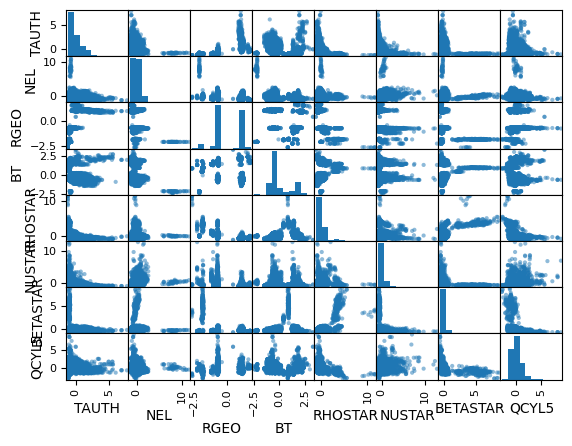

In [5]:
features = ['TAUTH','NEL','RGEO','BT','RHOSTAR','NUSTAR','BETASTAR','QCYL5']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

In [6]:
X = DB5_[features].to_numpy() # Getting scaled dataset
y = DB5[["label"]].to_numpy().reshape(-1)

# create the model | Default Configuration
model = RandomForestClassifier(random_state=71)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

In [7]:
# Accuracy
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

1.0
0.9248400852878464


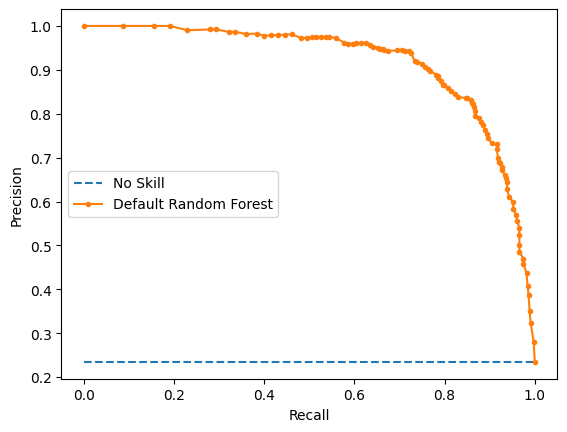

In [8]:
# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Default Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [9]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.88040712, 0.93661497]),
 array([0.78636364, 0.96727019]),
 array([0.83073229, 0.95169579]),
 array([ 440, 1436]))

## Features ordered by Entropy Analysis

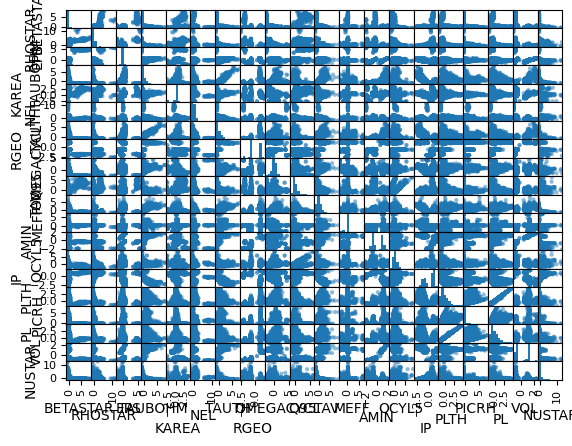

In [10]:
features = ['BETASTAR', 'RHOSTAR', 'EPS', 'TAUBOHM', 'KAREA', 'NEL', 'TAUTH', 
            'RGEO', 'OMEGACYCL', 'Q95', 'TAV', 'MEFF', 'AMIN', 'QCYL5', 'IP', 
            'PLTH', 'PICRH', 'PL', 'VOL', 'NUSTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

In [19]:
df = DB5_[features]
df["label"] = DB5["label"]
df = df.dropna()

In [20]:
X = df[features].to_numpy() # Getting scaled dataset
y = df["label"].to_numpy().reshape(-1)

# create the model | Default Configuration
model = RandomForestClassifier(random_state=71)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

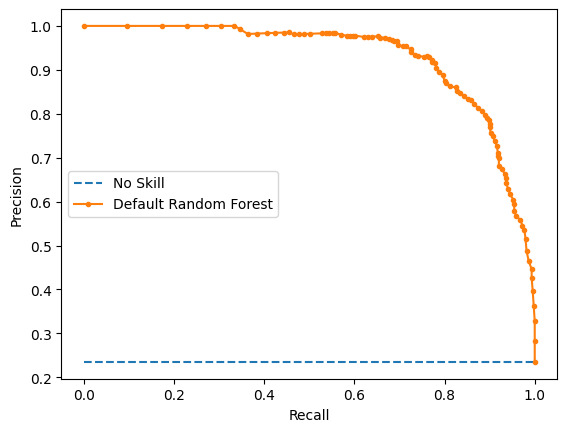

In [21]:
# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Default Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

In [22]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.91466667, 0.93520374]),
 array([0.77954545, 0.97765363]),
 array([0.84171779, 0.95595766]),
 array([ 440, 1432]))